# Data Preprocessing

In [1]:
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

In [12]:
# Folder containing CSVs with sequences of loss values
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\filtered-search\cnns\cifar10\categorical'
input_window = 9
output_window = 1  

sequences = []

# Load all CSVs and extract sequences of loss values
for filename in [i for i in os.listdir(folder_path) if i.endswith(".csv")]:
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            if len(data) >= input_window + output_window: 
                values_temp = data['Loss'].values
                if max(values_temp) < 2.5 and min(values_temp) >= 0:  # make sure data makes sense
                    sequences.append(values_temp)
        except:
            print(filename)

flattened = list(itertools.chain(*sequences))
mean, std = np.mean(flattened), np.std(flattened)
print("number of sequences:", len(sequences), "mean:", mean, "std:", std)

number of sequences: 424 mean: 0.6949442123005762 std: 0.4846767002923874


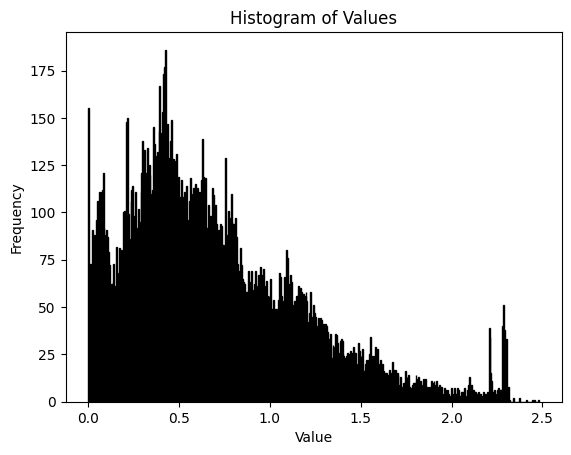

In [13]:
plt.hist(flattened, bins=500, edgecolor='black')  
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')
plt.show()

In [14]:
train_split = 0.8
train_sequences, test_sequences = sequences[:int(len(sequences) * train_split)], sequences[int(len(sequences) * train_split):]
len(train_sequences), len(test_sequences)

(339, 85)

# Model Architecture

In [17]:
class FloatSequenceTransformer(nn.Module):
    def __init__(self, embedding_dim=64, num_heads=4, num_layers=6, dropout=0.2):
        super(FloatSequenceTransformer, self).__init__()
        
        self.embedding = nn.Linear(1, embedding_dim)
        self.embedding_dim = embedding_dim

        transformer_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, 
                                                       batch_first=True, dropout=dropout)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        self.output_layer = nn.Linear(embedding_dim, 1)
        self.positional_encoding = None

    def generate_positional_encoding(self, seq_length, device):
        if self.positional_encoding is None or self.positional_encoding.size(0) != seq_length:
            position = torch.arange(seq_length, device=device).unsqueeze(1).float()
            div_term = torch.exp(torch.arange(0, self.embedding_dim, 2, device=device).float() * -(np.log(10000.0) / self.embedding_dim))
            pe = torch.zeros(seq_length, self.embedding_dim, device=device)
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            self.positional_encoding = pe
        return self.positional_encoding

    def forward(self, x):
        seq_length = x.size(1)
        x = self.embedding(x)
        positional_encoding = self.generate_positional_encoding(seq_length, x.device)
        x = x + positional_encoding
        mask = torch.triu(torch.ones(seq_length, seq_length, device=x.device) * float('-inf'), diagonal=1)
        x = self.transformer(x, mask=mask)
        x = self.output_layer(x)
        return x[:, -1, :]

# Instantiate model, loss, and optimizer
model = FloatSequenceTransformer() 
criterion = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  # Halve LR every 5 epochs
clip_value = 1.0 

## Training

In [ ]:
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for sequence in tqdm(train_sequences):
        sequence = (sequence - mean) / std  # Normalize the sequence
        input_sequence = torch.tensor(sequence[:input_window], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # Shape: (1, input_window, 1)
        
        total_loss = 0.0  # Accumulate loss over the sequence
        for i in range(input_window, len(sequence)):
            # Predict the next value based on the current input sequence
            predicted_value = model(input_sequence)

            # Define the target as the next value in the sequence
            target_value = torch.tensor([sequence[i]], dtype=torch.float32).unsqueeze(0)
            
            # Compute loss
            loss = criterion(predicted_value, target_value)
            total_loss += loss  # Accumulate loss

            # Update input_sequence with the predicted value, shifting by one step
            input_sequence = torch.cat([input_sequence[:, 1:, :], predicted_value.unsqueeze(-1).detach()], dim=1)
        
        # Perform backpropagation once per sequence
        optimizer.zero_grad()
        total_loss.backward()  # Backpropagate on accumulated loss
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        optimizer.step()
        
        # Accumulate epoch loss
        epoch_loss += total_loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(test_sequences)}")


100%|████████████████████████████████████████████████████████████████████████████████| 339/339 [06:37<00:00,  1.17s/it]


Epoch [1/10], Loss: 86.08218326543822


 22%|█████████████████▋                                                               | 74/339 [01:19<03:53,  1.13it/s]

## Test trained model

In [51]:
def predict_next_value(model, sequence):
    model.eval()
    with torch.no_grad():
        input_sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1) # Shape: (1, seq_length, 1)
        prediction = model(input_sequence)
        return prediction.item()

In [61]:
[print(i,j) for i,j in results_hallucinate]

[1.52461379 1.32114651 1.20807143 1.13987742 1.09446322 1.04938828
 1.0148793  0.98652572 0.96146793 0.93796111 0.9198342  0.89812069
 0.88362885 0.86438719 0.85459672 0.84514552 0.83070216 0.8247891
 0.8133992  0.80811622 0.8054505  0.79667785 0.79202496 0.78674198
 0.7843186  0.78102279 0.77515821 0.78044118 0.77205628 0.77035991
 0.76720951 0.76876047 0.76425298 0.76444685 0.76415605 0.76313822
 0.76279895 0.75761291 0.76153879 0.7570313  0.75751597 0.7520876
 0.75596501 0.75257227 0.75596501 0.75179679 0.75010042 0.75296001
 0.75392937 0.7507305  0.75286308 0.74602914 0.74510825 0.74646535
 0.74976115 0.74821018 0.74724083 0.74452664 0.74573833 0.74651381
 0.74389656 0.74496285 0.74244253 0.74384809 0.74244253 0.74171551
 0.7444297  0.74438124 0.74268487 0.74307261 0.74176398 0.74409043
 0.74123084 0.73827431 0.73793504 0.74089156 0.73880745 0.74176398
 0.73924366 0.74190938 0.73788657 0.73657794 0.74103697 0.73841971
 0.73977681 0.73725649 0.73648101 0.73851665 0.74176398 0.736238

[None, None]

In [63]:
results_hallucinate = []
for sequence in test_sequences: 
    real_sequence, predicted_sequence = sequence, list(sequence[:input_window])
                                                                             
    for i in range(input_window, len(sequence)):
        if i == input_window:
            previous_input = sequence[:input_window]
        y_hat = predict_next_value(model, previous_input)
        previous_input = np.concatenate((previous_input, np.array([y_hat])))
        
    predicted_sequence = previous_input
    real_sequence, predicted_sequence = real_sequence * std + mean, predicted_sequence * std + mean
    print(list(real_sequence)[input_window:], "\n",list(predicted_sequence)[input_window:], "\n\n")
    results_hallucinate.append((real_sequence, predicted_sequence))

[1.3462527621534863, 1.3418422041808258, 1.3374801138781942, 1.3321971378450073, 1.3291921423031945, 1.322794409859335, 1.3218735241287793, 1.3174629661561186, 1.3120830547828732, 1.3109198307021712, 1.3048613719485165, 1.3058307253491013, 1.2999661372755633, 1.300887023006119, 1.2981728334844815, 1.2928413897812654] 
 [0.3057223726000359, 0.30615775845607457, 0.30620060081719896, 0.30620554083321533, 0.3061769118515064, 0.30613372282259144, 0.3061080405171029, 0.30611956722114103, 0.3061702096075544, 0.3062269475692862, 0.30626340546526665, 0.3062751343921827, 0.3062734010532296, 0.30627605883962433, 0.30628692109706385, 0.306288134434331] 


[1.034508708525423] 
 [0.30572185259834994] 


[0.9874950685970613, 0.9811942714932602, 0.9772683902208918, 0.9633097012524712, 0.9583659989094888, 0.9517259281154831, 0.9411599760491091, 0.9276859637809807, 0.9186709771555422, 0.9147935635532032, 0.8998170535141684, 0.8939524654406306, 0.886536911926157, 0.868264600325134, 0.859346549039754, 0.8

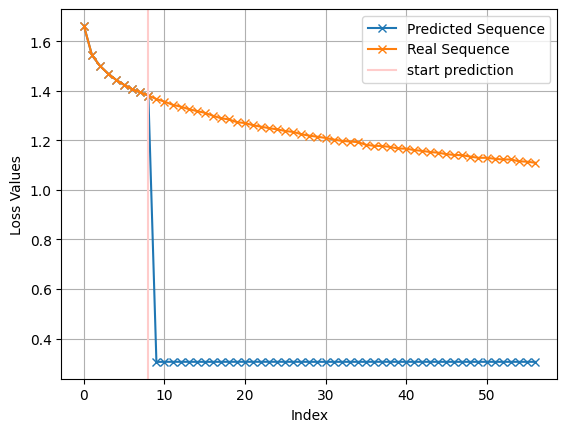

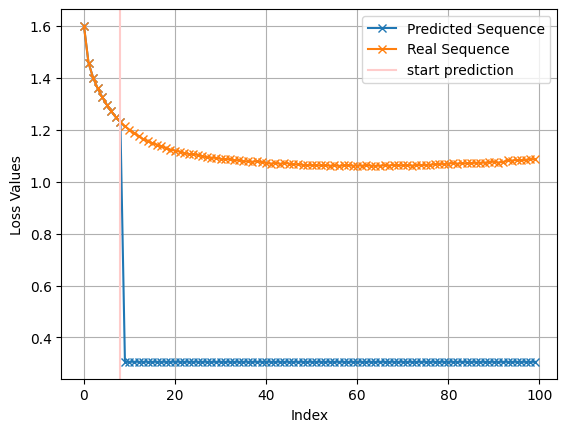

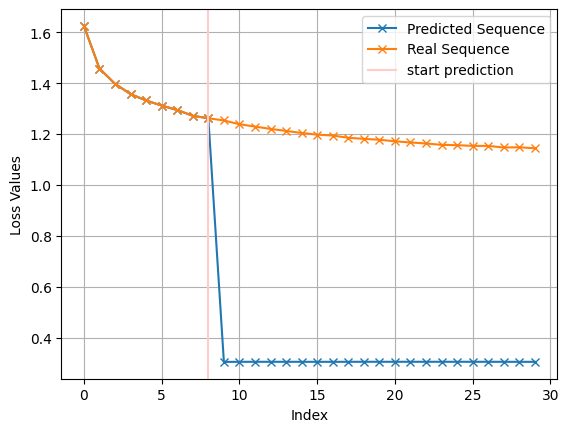

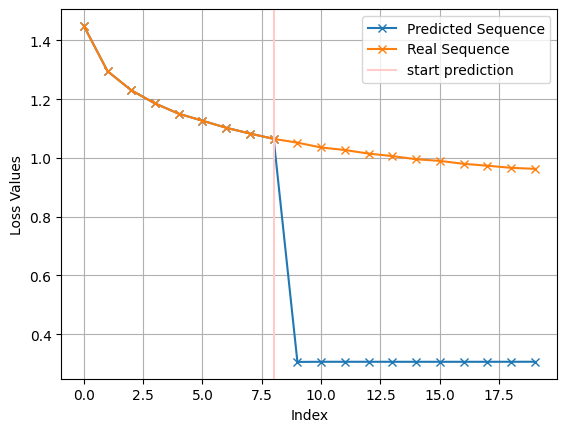

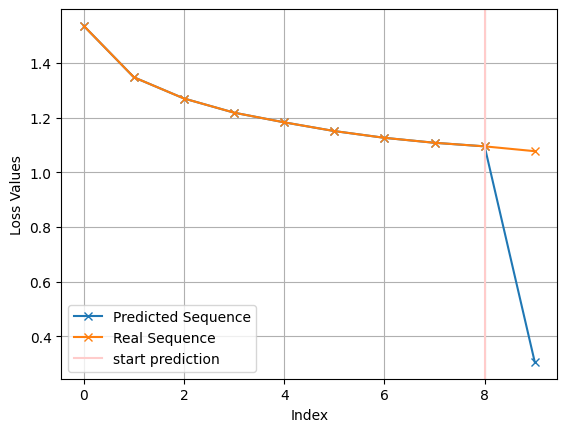

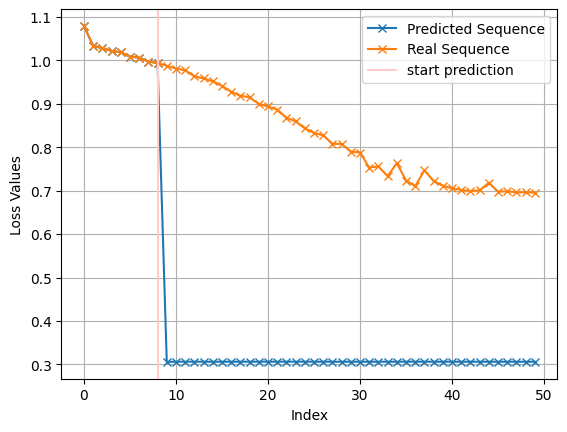

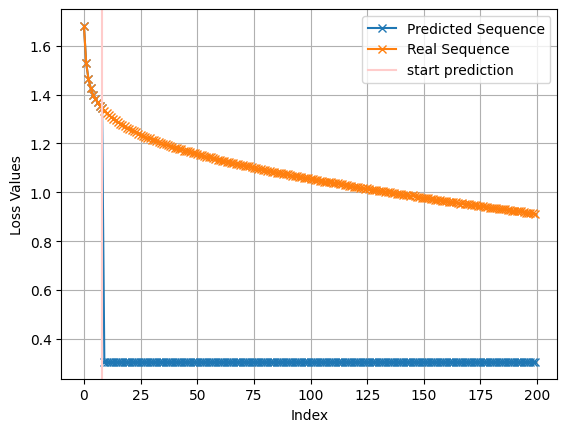

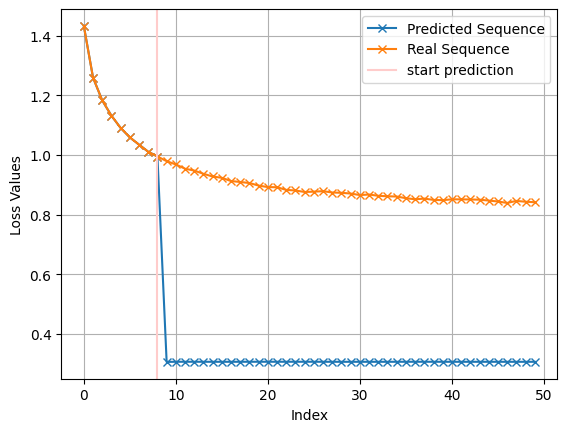

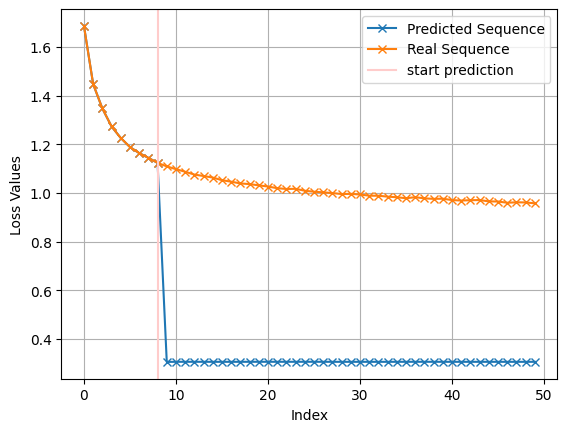

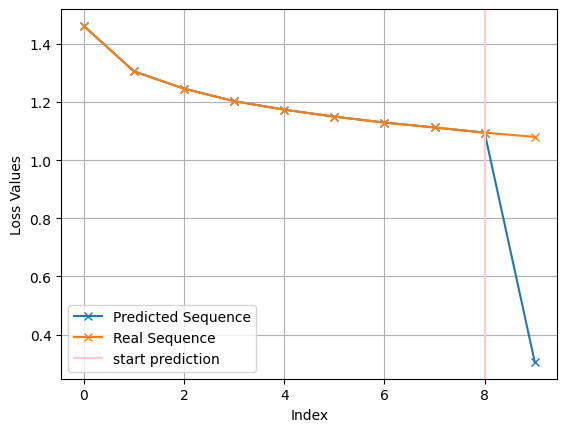

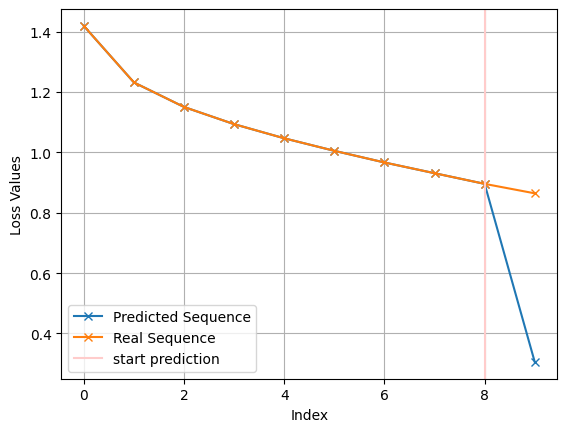

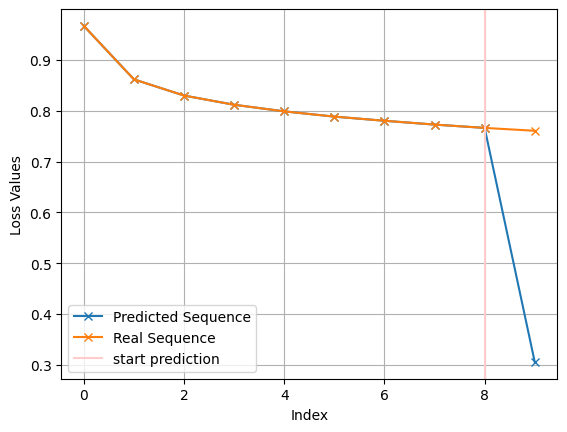

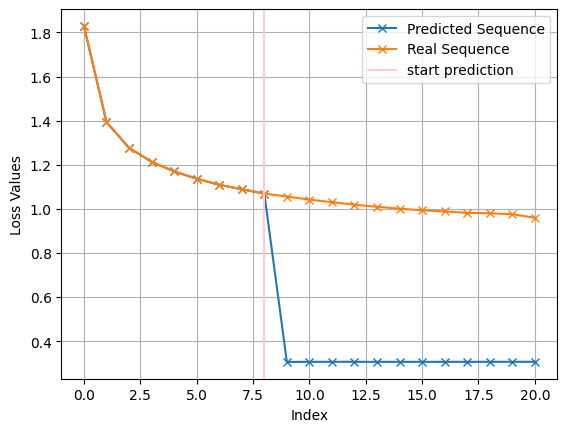

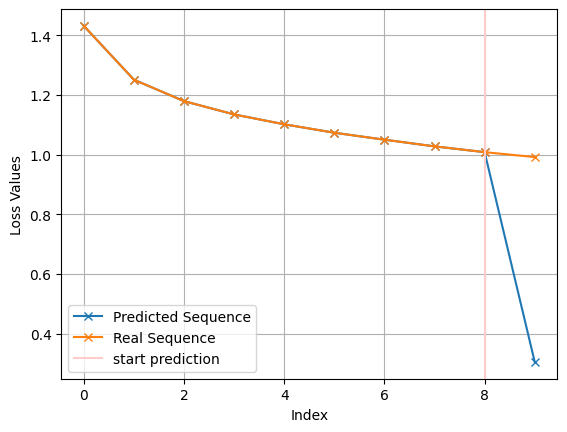

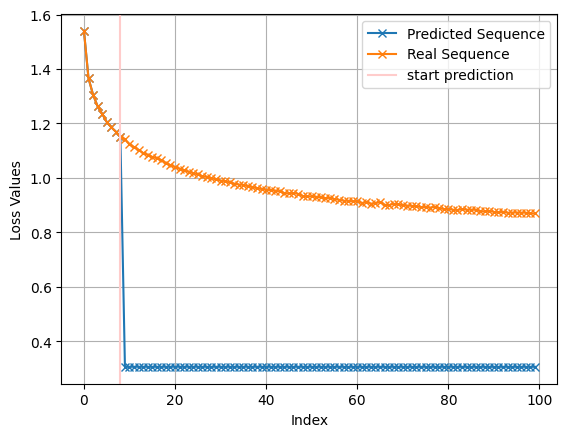

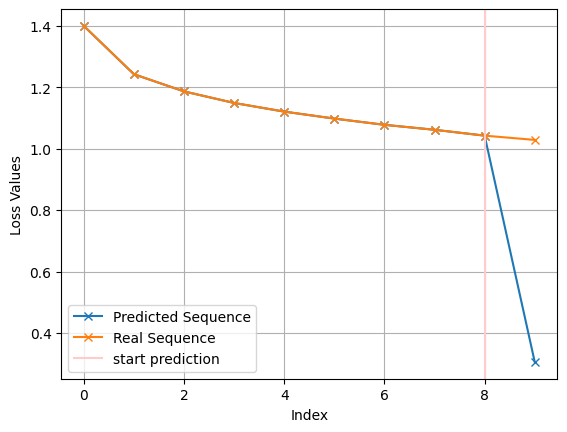

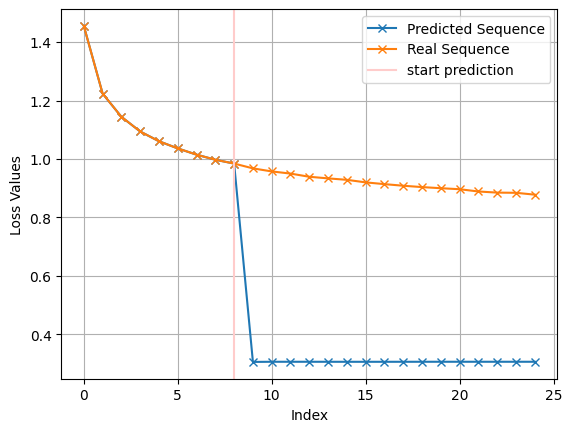

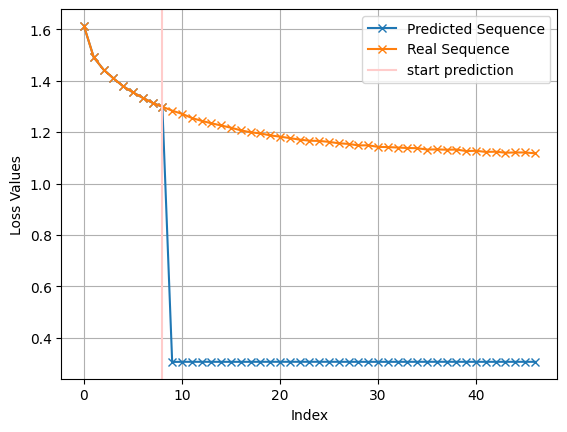

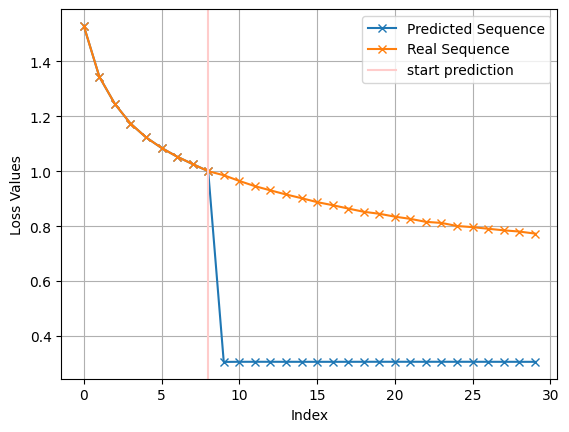

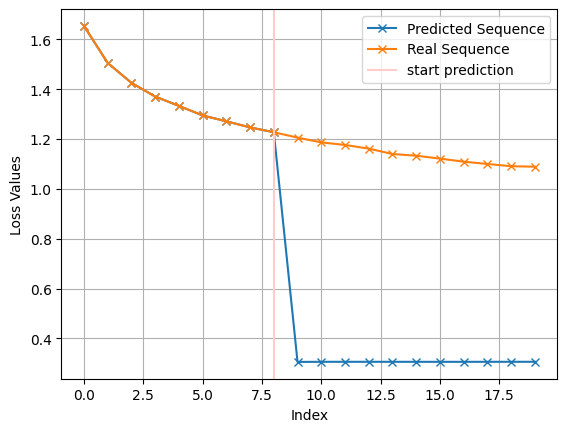

In [56]:
num_samples = 20

sample = random.sample(results_hallucinate, num_samples)
for i, (real_sequence, predicted_sequence) in enumerate(sample):
    plt.figure()
    plt.plot(predicted_sequence, label="Predicted Sequence", marker='x', linestyle='-')
    plt.plot(real_sequence, label="Real Sequence", marker='x', linestyle='-')
    plt.axvline(x=input_window-1, color='#ffcccb', linestyle='-', label="start prediction")
    
    plt.xlabel("Index")
    plt.ylabel("Loss Values")
    plt.legend()
    plt.grid()
    plt.show()

In [64]:
model_save_path = "models/trained_model_variable_length_bad.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/trained_model_variable_length_bad.pth
